### Configurable Variables
Variables that can be modified in this notebook
- `input_data` — path to the input folder containing the dataset
- `supress_warnings` — boolean flag to enable/disable warning messages (`True`/`False`)
---
**Set following variables if you are running notebook interactively.**

In [1]:
input_path_default = "output_datasets/SN124_A595688_Rep2/adata_QC_filtered.normalized.h5ad"
suppress_warnings_default = False

# SPATIAL TRANSCRIPTOMICS – IDENTIFICATION OF SVGs WITH SOMDE

Spatial transcriptomics links gene expression to tissue location. To find **spatially variable genes (SVGs)**, we use **SOMDE**, a fast method that detects spatial expression patterns using **self-organizing maps** and **statistical modeling**. This notebook demonstrates how to load data, run SOMDE, and visualize the resulting SVGs.


### Load variables from CMD

In [2]:
SUPPRESS_WARNINGS = None
try:
    if suppress_warnings == "True":
        SUPPRESS_WARNINGS = True
    else:
        SUPPRESS_WARNINGS = False
except NameError:
    SUPPRESS_WARNINGS = suppress_warnings_default

## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.
* Comment out the line below if warnings are desired for debugging.

In [3]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [4]:
# use conda env from readme

2. Import necessary libraries:

In [5]:
# Import of libraries for working with spatial transcriptomics data
import os
import sys
import somoclu
from somde import plotgene
from somde import SomNode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

3. load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.

In [24]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# OPTION 2
DATA_PATH = None
try:
    DATA_PATH = input_data
except NameError:
    DATA_PATH = input_path_default

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: Datapath (", DATA_PATH ,") not found.")
    sys.exit()

print("Using input path:", DATA_PATH)

DATA_FOLDER_NAME = DATA_PATH.split("/")[-2].strip()

save_dir = "figures/show/somde/" + DATA_FOLDER_NAME
os.makedirs(save_dir, exist_ok=True)

Using input path: output_datasets/SN124_A595688_Rep2/adata_QC_filtered.normalized.h5ad


# SOMDE analaysis

In [7]:
data_folder = "output_datasets/SN124_A595688_Rep2/"

# Load expression counts
df = pd.read_csv(os.path.join(data_folder, "count.csv"), sep=',', index_col=0)
print("Counts shape:", df.shape)

# Load metadata / spot info
corinfo = pd.read_csv(os.path.join(data_folder, "idx.csv"), sep=',', index_col=0)

# Add total counts per spot (sum across genes) with proper alignment
total_counts = df.sum(axis=1)
corinfo["total_count"] = total_counts.reindex(corinfo.index)
print(corinfo.head())

# Extract spatial coordinates
X = corinfo[['x', 'y']].values.astype(np.float32)

# Preview
print("Counts matrix shape:", df.shape)
print(df.head())
print("Spatial coordinates shape:", X.shape)
print("Metadata preview:")
print(corinfo.sort_values(by=['x', 'y'], ascending=True).head())

Counts shape: (387, 36601)
                       x     y   total_count
AAACCGTTCGTCCAGG-1   722  1308  24179.899155
AAAGGCTCTCGCGCCG-1   886  1375  26541.410022
AAAGGGATGTAGCAAG-1   975   691  23970.727229
AAATTAACGGGTAGCT-1   925   912  26947.427159
AACCGAGCTTGGTCAT-1  1077   691  22456.299749
Counts matrix shape: (387, 36601)
                    MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACCGTTCGTCCAGG-1          0.0      0.0    0.0         0.0         0.0   
AAAGGCTCTCGCGCCG-1          0.0      0.0    0.0         0.0         0.0   
AAAGGGATGTAGCAAG-1          0.0      0.0    0.0         0.0         0.0   
AAATTAACGGGTAGCT-1          0.0      0.0    0.0         0.0         0.0   
AACCGAGCTTGGTCAT-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.5  AL627309.4  AP006222.2  \
AAACCGTTCGTCCAGG-1         0.0         0.0         0.0         0.0   
AAAGGCTCTCGCGCCG-1         0.0         0.0         0.0         0.0   
AAAGGGAT

In [8]:
som = SomNode(X, 1)

using 19*19 SOM nodes for 387 points


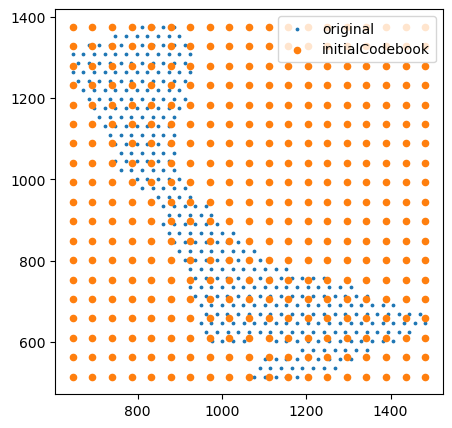

In [9]:
som.viewIniCodebook()

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig(
    f"figures/show/somde/{DATA_FOLDER_NAME}/ini_codebook.png",
    dpi=300,
    bbox_inches="tight"
)

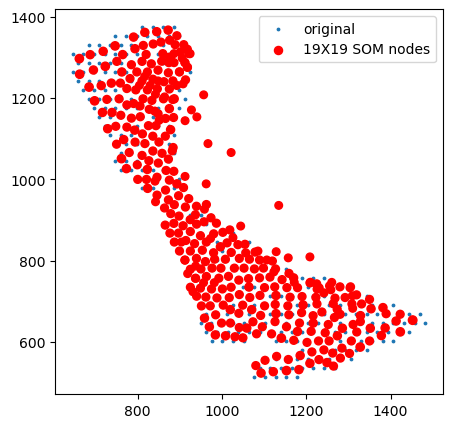

In [10]:
# Plot the SOM (creates its own figure)
som.view()

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig(
    f"figures/show/somde/{DATA_FOLDER_NAME}/somde_points.png",
    dpi=300,
    bbox_inches="tight"
)

In [11]:
ndf, ninfo = som.mtx(df.T)
print(ndf.shape)
print(ninfo.shape)


(36601, 308)
(308, 3)


In [97]:
#gene_names = df.columns

# To see the first few gene names
#print("First 10 available gene names:")
#print(gene_names[:10])


'''plotgene(
    X=X_nodes,          # Uses the corrected (scaled) grid coordinates
    mtx=ndf,
    draw_list=gene_names[10:15],
    result=som,
    sp=100,             # Large point size
    lw=0.2,
    N=10,
    plotsize=5
)'''

'plotgene(\n    X=X_nodes,          # Uses the corrected (scaled) grid coordinates\n    mtx=ndf,\n    draw_list=gene_names[10:15],\n    result=som,\n    sp=100,             # Large point size\n    lw=0.2,\n    N=10,\n    plotsize=5\n)'

In [13]:
nres = som.norm()
result, SVnum =som.run()

Models: 100%|██████████| 10/10 [05:42<00:00, 34.24s/it]


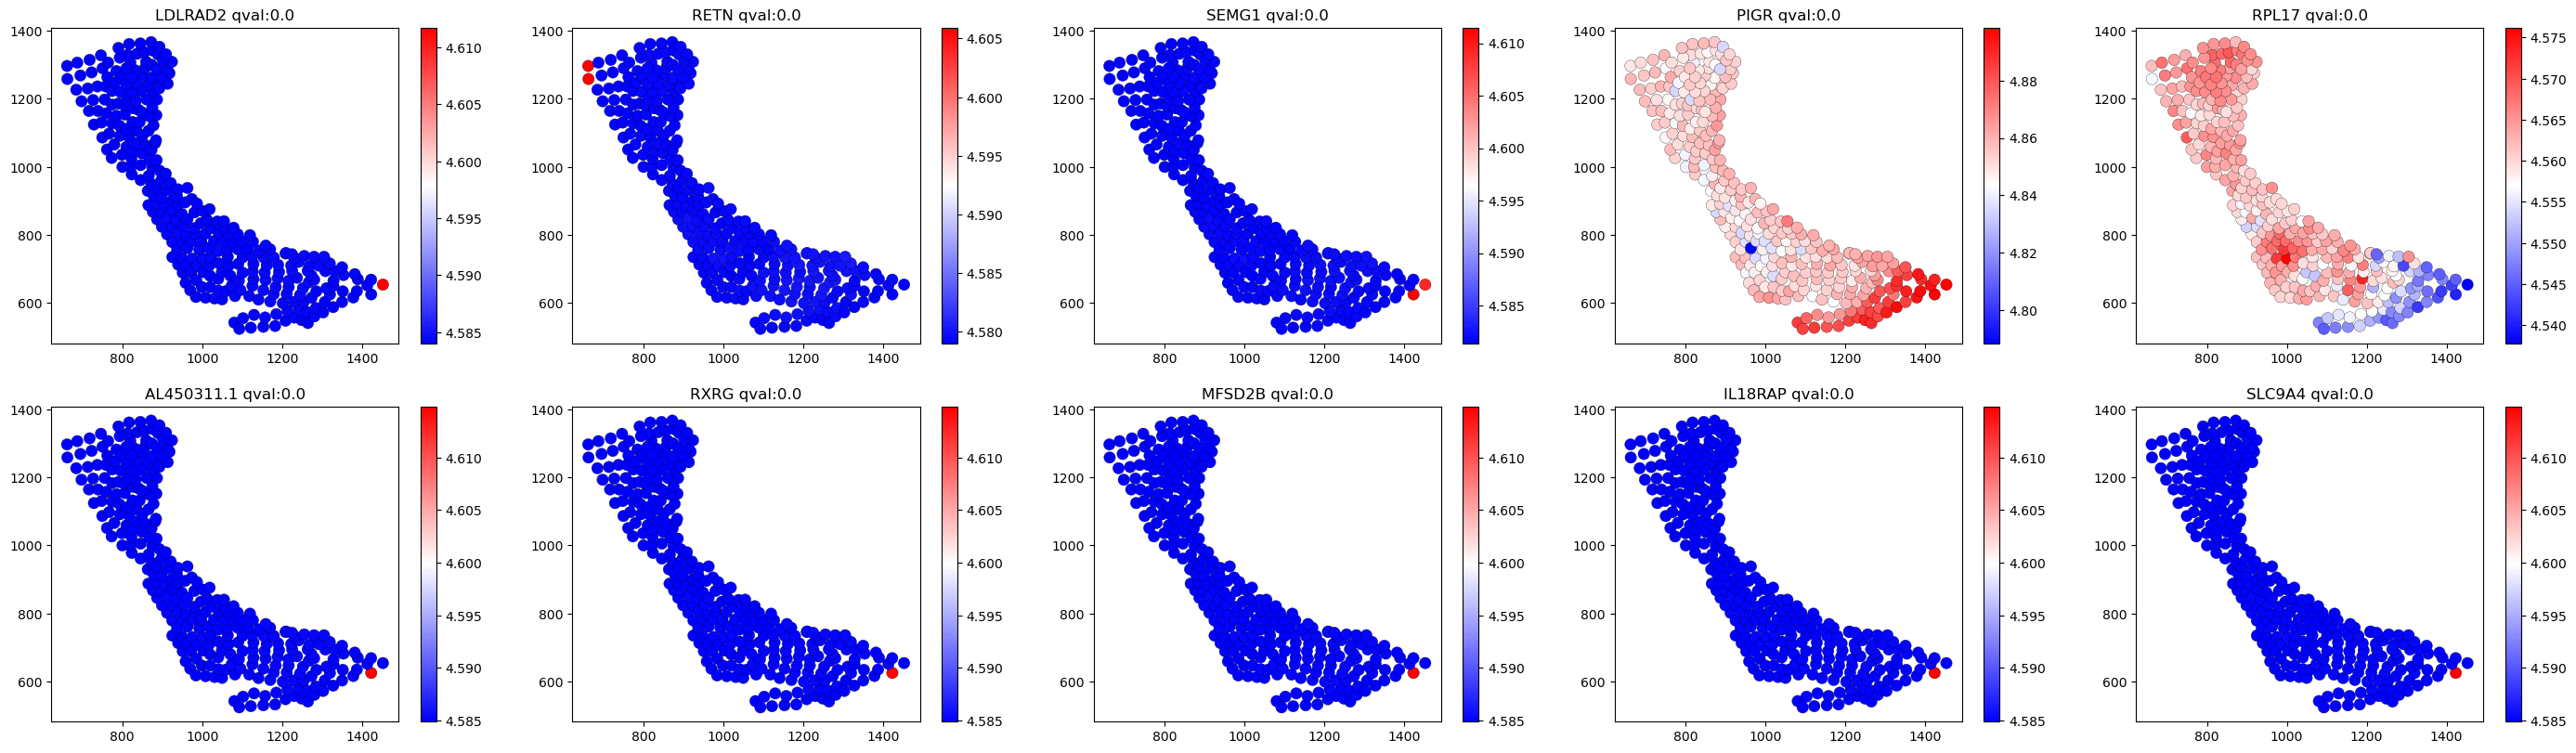

In [16]:
plotgene(ninfo[['x','y']].values,nres.T,result.g.to_list()[20:30],result,sp=80,lw=0.2,plotsize=5)

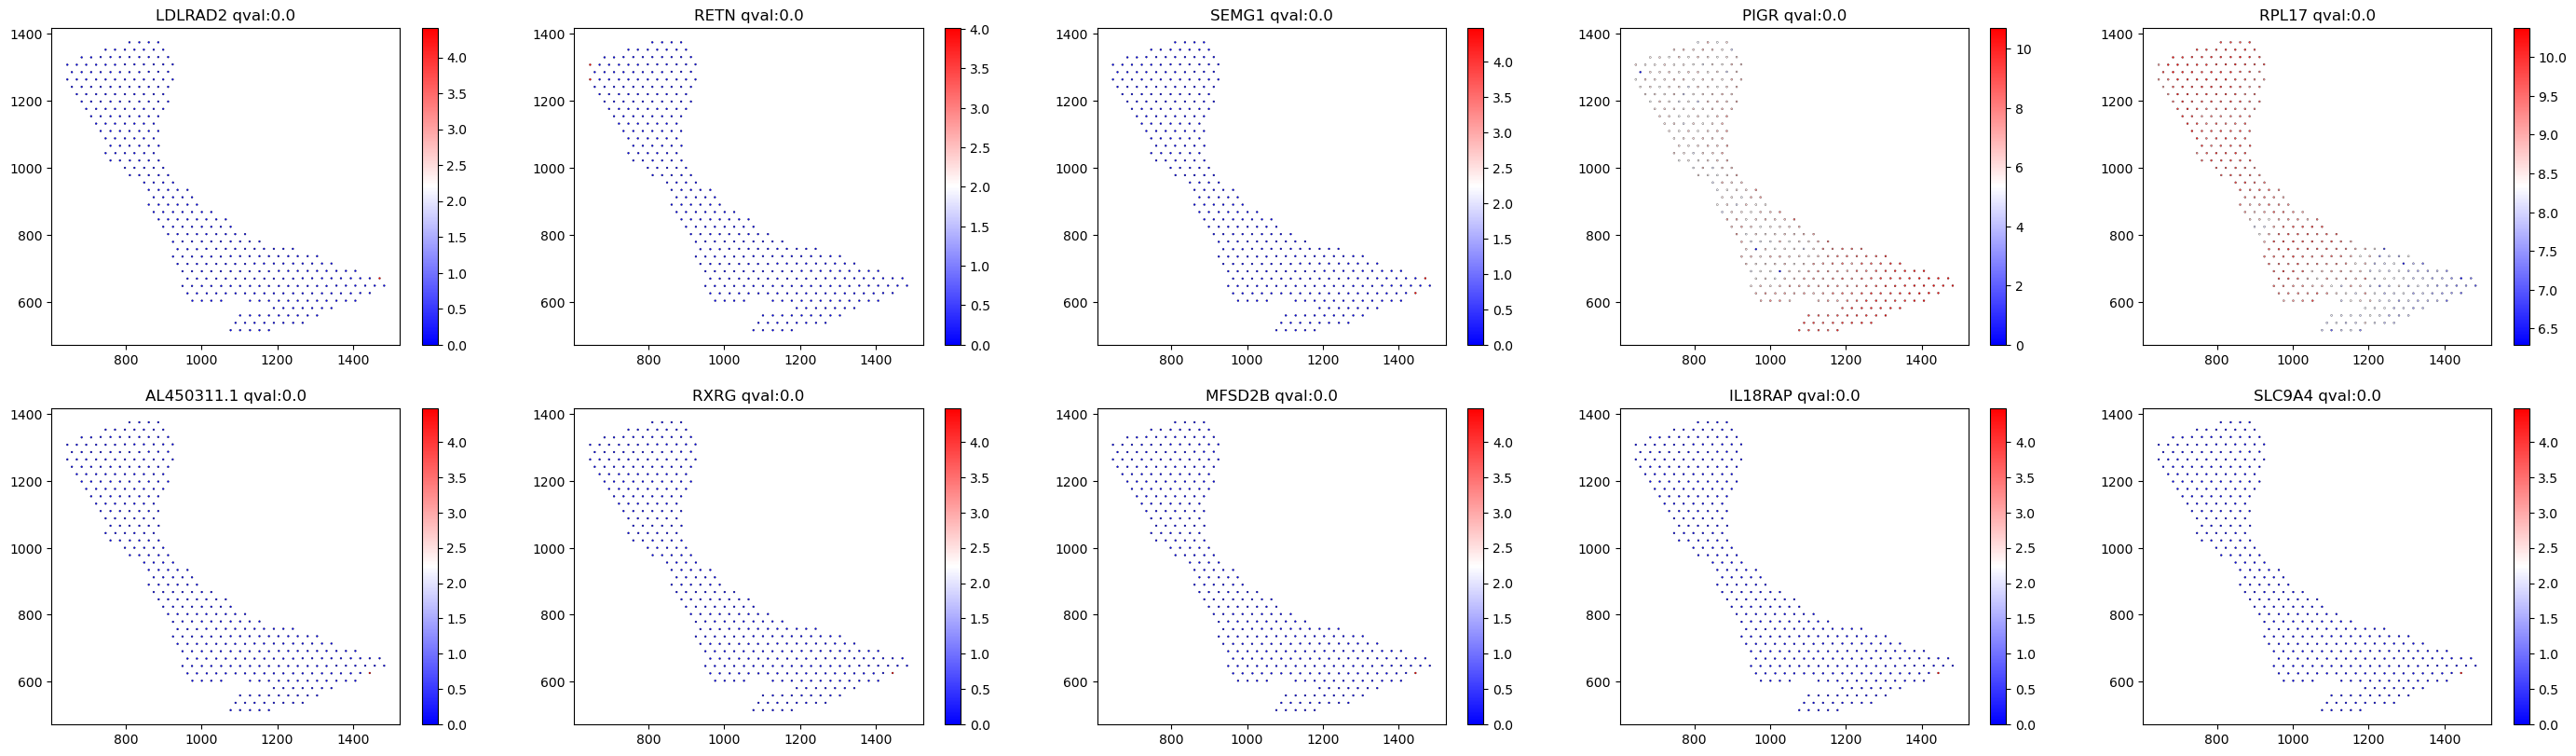

In [21]:
plotgene(corinfo[['x','y']].values,df.T,result.g.to_list()[20:30],result,sp=2,lw=0.2,plotsize=5)

In [20]:
SVnum

23441

In [19]:
result[:50]

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
32584,0.999951,4,AL391650.1,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000332,-3930.795250,1621.910348,354.947477,0.0,0.0
34633,0.999951,4,TNMD,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000342,-3930.795250,1621.910348,354.947477,0.0,0.0
33697,0.999951,4,CCDC73,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000380,-3930.795250,1621.910348,354.947477,0.0,0.0
33738,0.999951,4,AP000759.1,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000335,-3930.795250,1621.910348,354.947477,0.0,0.0
33805,0.999951,4,CLEC4E,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000353,-3930.795250,1621.910348,354.947477,0.0,0.0
32981,0.999951,4,LINC02068,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000368,-3930.795250,1621.910348,354.947477,0.0,0.0
34489,0.999951,4,PTPRT,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000360,-3930.795250,1621.910348,354.947477,0.0,0.0
34061,0.999951,4,CPLX3,62.917564,0.000045,1976.857825,4.587237,1.333914,SE,308,2.283831e-11,0.006750,0.000342,-3930.795250,1621.910348,354.947477,0.0,0.0
32890,0.999951,4,RBMS3-AS3,62.917564,0.000045,1856.642066,4.587108,1.333960,SE,308,2.283831e-11,0.006750,0.000343,-3690.363734,1501.694590,354.947477,0.0,0.0
33240,0.999951,4,CAPN11,62.917564,0.000045,1856.642066,4.587108,1.333960,SE,308,2.283831e-11,0.006750,0.000341,-3690.363734,1501.694590,354.947477,0.0,0.0
